# Training with Azure ML


## Prerequisite:
* Understand the [architecture and terms](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture) introduced by Azure Machine Learning
* If you are using an Azure Machine Learning Compute Instance, you are all set. Otherwise follow below steps:
    * install the AML SDK
    * create a workspace and its configuration file (`config.json`)
* For local scoring test, you will also need to have `tensorflow` and `keras` installed in the current Jupyter kernel.

Let's get started. First let's import some Python libraries.

In [ ]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [ ]:
import azureml
from azureml.core import Workspace, Datastore, Dataset

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

## Initialize workspace
Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`.

In [ ]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

## Create an Azure ML experiment
Let's create an experiment named "Covid19-Classification" and a folder to hold the training scripts. The script runs will be recorded under the experiment in Azure.

In [ ]:
from azureml.core import Experiment

script_folder = './Covid19Scripts'
os.makedirs(script_folder, exist_ok=True)

exp = Experiment(workspace=ws, name='Covid19-Classification-CNN')

Now you have an idea of what these images look like and the expected prediction outcome.

## Create and Register ADLS Gen 2 Datastore
Azure Machine Learning datastores securely keep the connection information to your data storage on Azure, so you don't have to code it in your scripts. Register and create a datastore to easily connect to your storage account, and access the data in your underlying storage service.

Supported cloud-based storage services in Azure that can be registered as datastores:

Azure Blob Container

Azure File Share

Azure Data Lake Gen2

Azure SQL Database

Azure Database for PostgreSQL

Databricks File System

Azure Database for MySQL

[Learn more](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-access-data)

In [ ]:
adlsgen2_datastore_name = '<my_datastore>' #name of datastore that you want to register

subscription_id=os.getenv("ADL_SUBSCRIPTION", "<my_subscription_id>") # subscription id of ADLS account
resource_group=os.getenv("ADL_RESOURCE_GROUP", "<my_resource_group>") # resource group of ADLS account

account_name=os.getenv("ADLSGEN2_ACCOUNTNAME", "<my_account_name>") # ADLS Gen2 account name
tenant_id=os.getenv("ADLSGEN2_TENANT", "<my_tenant_id>") # tenant id of service principal
client_id=os.getenv("ADLSGEN2_CLIENTID", "<my_client_id>") # client id of service principal
client_secret=os.getenv("ADLSGEN2_CLIENT_SECRET", "<my_client_secret>") # the secret of service principal

adlsgen2_datastore = Datastore.register_azure_data_lake_gen2(workspace=ws,
                                                             datastore_name=adlsgen2_datastore_name,
                                                             account_name=account_name, # ADLS Gen2 account name
                                                             filesystem='my_container', # ADLS Gen2 filesystem
                                                             tenant_id=tenant_id, # tenant id of service principal
                                                             client_id=client_id, # client id of service principal
                                                             client_secret=client_secret) # the secret of service principal

In [ ]:
# Get a named datastore from the current workspace
adlsgen2_datastore = Datastore.get(ws, datastore_name='shriadlsgen2datastore')

In [ ]:
# List all datastores registered in the current workspace
datastores = ws.datastores
for name, datastore in datastores.items():
    print(name, datastore.datastore_type)

## Create a FileDataset
A FileDataset references one or multiple files in your datastores or public urls. The files can be of any format. FileDataset provides you with the ability to download or mount the files to your compute. By creating a dataset, you create a reference to the data source location. If you applied any subsetting transformations to the dataset, they will be stored in the dataset as well. The data remains in its existing location, so no extra storage cost is incurred. [Learn More](https://aka.ms/azureml/howto/createdatasets)

In [ ]:
# create a FileDataset pointing to files in 'train' folder and its subfolders recursively
train_datastore_paths = [(adlsgen2_datastore, 'train')]
dataset = Dataset.File.from_files(path=train_datastore_paths)

Use the `register()` method to register datasets to your workspace so they can be shared with others, reused across various experiments, and referred to by name in your training script.
You can try get the dataset first to see if it's already registered.

In [ ]:
dataset_registered = False
try:
    temp = Dataset.get_by_name(workspace = ws, name = 'covid19-train-dataset')
    dataset_registered = True
    print("covid19-train-dataset already exists")
except:
    print("The dataset covid19-train-dataset is not registered in workspace yet.")

if not dataset_registered:
    dataset = dataset.register(workspace = ws,
                               name = 'covid19-train-dataset',
                               description='Covid-19 training dataset',
                               create_new_version=True)
    print("Registering covid19-train-dataset...")

In [ ]:
dataset_train = Dataset.get_by_name(ws, 'covid19-train-dataset')

# list the files referenced by mnist dataset
dataset_train.to_path()

In [ ]:
# create a FileDataset pointing to files in 'train' folder and its subfolders recursively
datastore_paths = [(adlsgen2_datastore, 'test')]
dataset = Dataset.File.from_files(path=datastore_paths)

dataset_registered = False
try:
    temp = Dataset.get_by_name(workspace = ws, name = 'covid19-test-dataset')
    dataset_registered = True
    print("covid19-test-dataset already exists")
except:
    print("The dataset covid19-test-dataset is not registered in workspace yet.")

if not dataset_registered:
    dataset = dataset.register(workspace = ws,
                               name = 'covid19-test-dataset',
                               description='Covid-19 training dataset',
                               create_new_version=True)
    print("Registering covid19-test-dataset...")

In [ ]:
dataset_test = Dataset.get_by_name(ws, 'covid19-test-dataset')

# list the files referenced by dataset
dataset_test.to_path()

## Create or Attach existing AmlCompute
You will need to create a [compute target](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#compute-target) for training your model. In this tutorial, you create `AmlCompute` as your training compute resource.

> Note that if you have an AzureML Data Scientist role, you will not have permission to create compute resources. Talk to your workspace or IT admin to create the compute targets described in this section, if they do not already exist.

If we could not find the cluster with the given name, then we will create a new cluster here. We will create an `AmlCompute` cluster of `Standard_NC6s_v2` (6 cores, 112 GB RAM, 336 GB disk) GPU VMs. This process is broken down into 3 steps:
1. create the configuration (this step is local and only takes a second)
2. create the cluster (this step will take about **20 seconds**)
3. provision the VMs to bring the cluster to the initial size (of 1 in this case). This step will take about **3-5 minutes** and is providing only sparse output in the process. Please make sure to wait until the call returns before moving to the next cell

### VM configuration

NCv2-series VMs are powered by NVIDIA Tesla P100 GPUs. These GPUs can provide more than 2x the computational performance of the NC-series. Customers can take advantage of these updated GPUs for traditional HPC workloads such as reservoir modeling, DNA sequencing, protein analysis, Monte Carlo simulations, and others. 

In addition to the GPUs, the NCv2-series VMs are also powered by Intel Xeon E5-2690 v4 (Broadwell) CPUs.

The NC24rs v2 configuration provides a low latency, high-throughput network interface optimized for tightly coupled parallel computing workloads.
https://docs.microsoft.com/en-us/azure/virtual-machines/ncv2-series



In [ ]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

# choose a name for your cluster
cluster_name = "gpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6S_V2', 
                                                           max_nodes=4)

    # create the cluster
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# can poll for a minimum number of nodes and for a specific timeout. 
# if no min node count is provided it uses the scale settings for the cluster
compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

# use get_status() to get a detailed status for the current cluster. 
print(compute_target.get_status().serialize())

Now that you have created the compute target, let's see what the workspace's `compute_targets` property returns. You should now see one entry named "gpu-cluster" of type `AmlCompute`.

In [ ]:
compute_targets = ws.compute_targets
for name, ct in compute_targets.items():
    print(name, ct.type, ct.provisioning_state)

In [ ]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
compute_target=ComputeTarget(workspace=ws, name="gpu-cluster")

## Copy the training files into the script folder
`train.py` is copied in Covid19Sciprts folder

# COVID-19 X-Ray image classification model using transfer learning technique 

### What Is Transfer Learning?

The training of a CNN involves, finding of the right values on each of the filters so that an input image when passed through the multiple layers, activates certain neurons of the last layer so as to predict the correct class.

Though training a CNN from scratch is possible for small data, most applications require the training of very large CNN’s and  takes extremely huge amounts of processed data and computational power. 

That’s where transfer learning comes into play. In transfer learning, we take the pre-trained weights of an already trained model(one that has been trained on millions of images belonging to 1000’s of classes, on several high power GPU’s for several days, in this case Xception model) and use these already learned features to predict new classes, in this case Covid-19 classification.

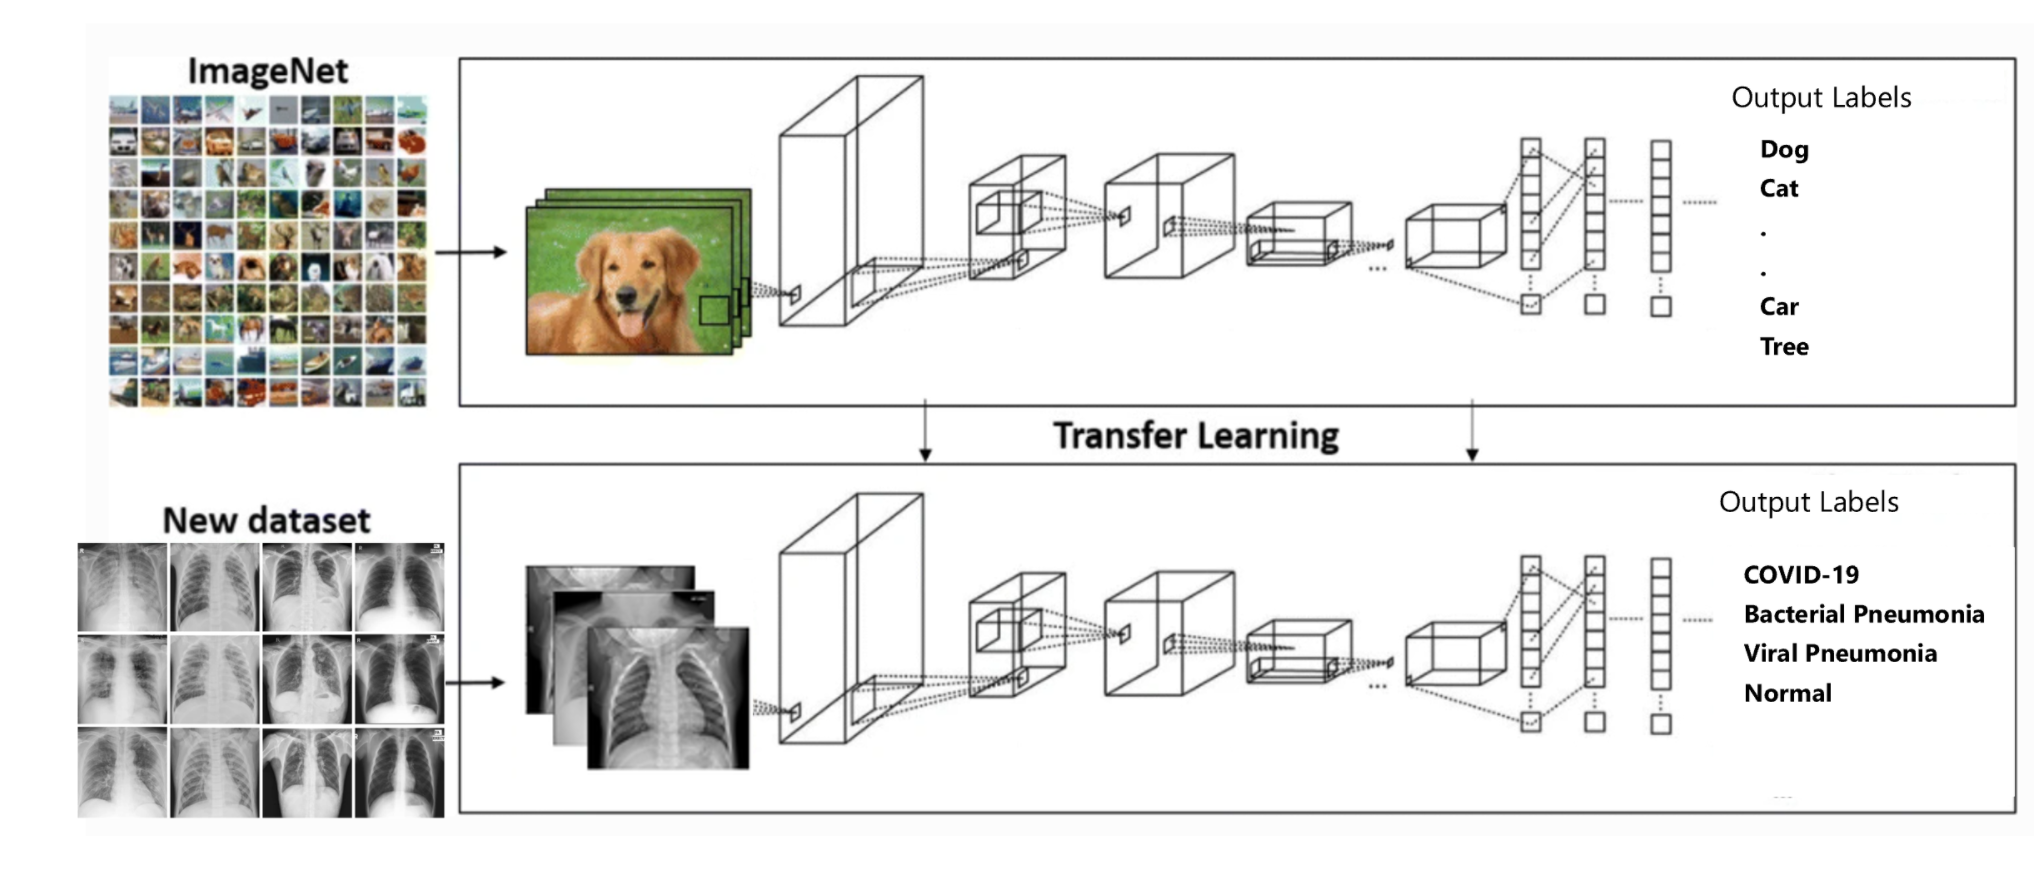

### State-of-the-art deep learning image classifiers in Keras
Keras ships out-of-the-box with five Convolutional Neural Networks that have been pre-trained on the ImageNet dataset:

1. VGG16

2. VGG19

3. ResNet50

4. Inception V3

5. Xception

We will be using [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/pdf/1610.02357.pdf) in this experiment.

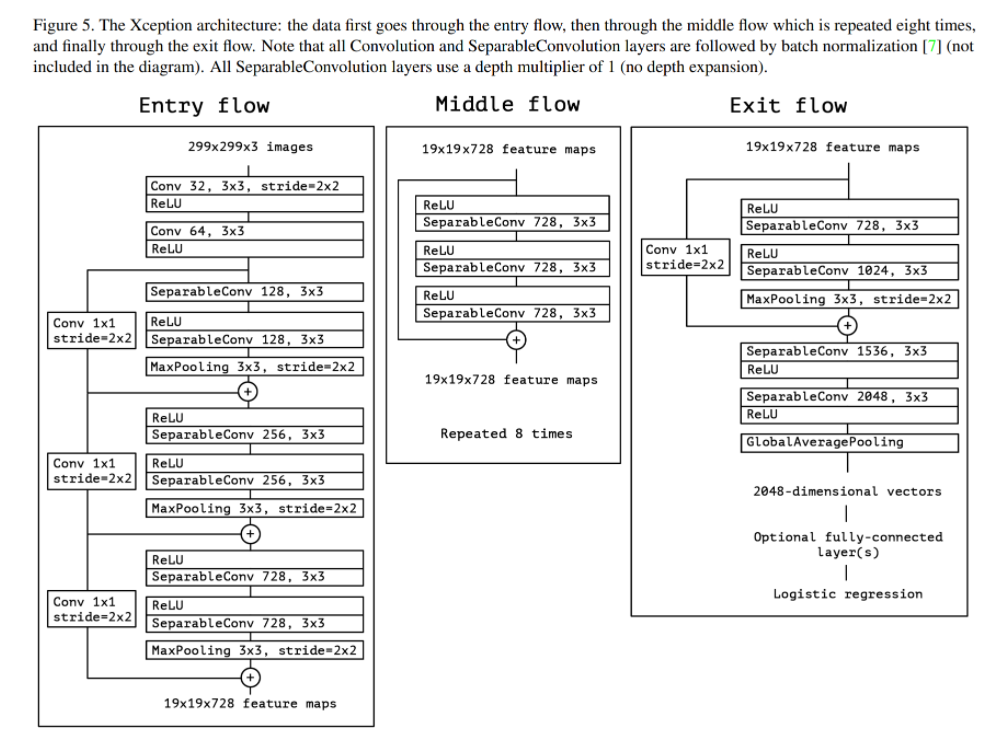

### Azure ML concepts  
Please note the following three things in the code below:
1. The script accepts arguments using the argparse package. In this case there is one argument `--data_folder` which specifies the FileDataset in which the script can find the  data
```
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_folder')
```
2. The script is accessing the Azure ML `Run` object by executing `run = Run.get_context()`. Further down the script is using the `run` to report the loss and accuracy at the end of each epoch via callback.
```
    run.log('Loss', log['val_loss'])
    run.log('Accuracy', log['val_accuracy'])
```
3. When running the script on Azure ML, you can write files out to a folder `./outputs` that is relative to the root directory. This folder is specially tracked by Azure ML in the sense that any files written to that folder during script execution on the remote target will be picked up by Run History; these files (known as artifacts) will be available as part of the run history record.

The next cell will print out the training code for you to inspect.

## Create an environment

Define a conda environment YAML file with your training script dependencies, which include TensorFlow, Keras and matplotlib, and create an Azure ML environment.

In [ ]:
%%writefile conda_dependencies_covid3.yml
dependencies:
  - pip:
      - azureml-sdk
      - azureml-widgets
      - tensorflow-gpu==2.0.0
      - keras<=2.3.1
      - matplotlib
      - pandas
      - numpy
  - python=3.6.2
name: train-covid-keras-tf

In [ ]:
from azureml.core import Environment

keras_env3 = Environment.from_conda_specification(name = 'covidkeras3', file_path = './conda_dependencies_covid3.yml')

# Specify a GPU base image
# keras_env2.docker.enabled = True
# keras_env2.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.0-cudnn7-ubuntu18.04'

In [ ]:
keras_env3

## Configure the training job

Create a ScriptRunConfig object to specify the configuration details of your training job, including your training script, environment to use, and the compute target to run on.

Note that we are specifying a DatasetConsumptionConfig for our FileDataset as an argument to the training script. Azure ML will resolve this DatasetConsumptionConfig to the mount-point of the backing datastore, which we access from the training script.

In [ ]:
from azureml.core import ScriptRunConfig

args = ['--train-data-folder', dataset_train.as_named_input('covid19_train_dataset').as_mount(),
        '--test-data-folder', dataset_test.as_named_input('covid19_test_dataset').as_mount(),
        '--batch-size', 10,
        '--num_epochs',5,
        '--learning-rate', 0.0001]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=keras_env3
                     )

In [ ]:
exp

## Submit job to run
Submit the ScriptRunConfig to the Azure ML experiment to kick off the execution.

In [ ]:
run = exp.submit(src)

### Monitor the Run
As the Run is executed, it will go through the following stages:
1. Preparing: A docker image is created matching the Python environment specified by the Azure ML environment, and it will be uploaded to the workspace's Azure Container Registry. This step will only happen once for each Python environment -- the container will then be cached for subsequent runs. Creating and uploading the image takes about **5 minutes**. While the job is preparing, logs are streamed to the run history and can be viewed to monitor the progress of the image creation.

2. Scaling: If the compute needs to be scaled up (i.e. the AmlCompute cluster requires more nodes to execute the run than currently available), the cluster will attempt to scale up in order to make the required amount of nodes available. Scaling typically takes about **5 minutes**.

3. Running: All scripts in the script folder are uploaded to the compute target, data stores are mounted/copied and the `entry_script` is executed. While the job is running, stdout and the `./logs` folder are streamed to the run history and can be viewed to monitor the progress of the run.

4. Post-Processing: The `./outputs` folder of the run is copied over to the run history

There are multiple ways to check the progress of a running job. We can use a Jupyter notebook widget. 

**Note: The widget will automatically update ever 10-15 seconds, always showing you the most up-to-date information about the run**

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

We can also periodically check the status of the run object, and navigate to Azure portal to monitor the run.

In [ ]:
run

In [ ]:
run.wait_for_completion(show_output=True)

In the outputs of the training script, it prints out the Keras version number. Please make a note of it.

### The Run object
The Run object provides the interface to the run history -- both to the job and to the control plane (this notebook), and both while the job is running and after it has completed. It provides a number of interesting features for instance:
* `run.get_details()`: Provides a rich set of properties of the run
* `run.get_metrics()`: Provides a dictionary with all the metrics that were reported for the Run
* `run.get_file_names()`: List all the files that were uploaded to the run history for this Run. This will include the `outputs` and `logs` folder, azureml-logs and other logs, as well as files that were explicitly uploaded to the run using `run.upload_file()`

Below are some examples -- please run through them and inspect their output. 

In [ ]:
run.get_details()

In [ ]:
run.get_metrics()

In [ ]:
run.get_file_names()

## Download the saved model

In the training script, the Keras model is saved into two files, `model.json` and `model.h5`, in the `outputs/models` folder on the gpu-cluster AmlCompute node. Azure ML automatically uploaded anything written in the `./outputs` folder into run history file store. Subsequently, we can use the `run` object to download the model files. They are under the the `outputs/model` folder in the run history file store, and are downloaded into a local folder named `model`.

In [ ]:
# create a model folder in the current directory
os.makedirs('./model', exist_ok=True)

for f in run.get_file_names():
    if f.startswith('outputs/model'):
        output_file_path = os.path.join('./model', f.split('/')[-1])
        print('Downloading from {} to {} ...'.format(f, output_file_path))
        run.download_file(name=f, output_file_path=output_file_path)

## Intelligent hyperparameter tuning
We have trained the model with one set of hyperparameters, now let's how we can do hyperparameter tuning by launching multiple runs on the cluster. First let's define the parameter space using random sampling.

In [ ]:
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, loguniform

ps = RandomParameterSampling(
    {
        '--batch-size': choice(10),
        '--num_epochs': choice(2,5),
        '--learning-rate': choice(0.0001)
    }
)

# ps = RandomParameterSampling(
#     {
#         '--batch-size': choice(10, 20),
#         '--num_epochs': choice(10, 30),
#         '--learning-rate': loguniform(-6, -1)
#     }
# )



Next, we will create a new ScriptRunConfig without the above arguments since they will be passed in later by our Hyperdrive configuration. Note we still need to keep the `data-folder` parameter since that's not a hyperparameter we will sweep.

Now we will define an early termnination policy. The `BanditPolicy` basically states to check the job every 2 iterations. If the primary metric (defined later) falls outside of the top 10% range, Azure ML terminate the job. This saves us from continuing to explore hyperparameters that don't show promise of helping reach our target metric.

In [ ]:
policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)

Now we are ready to configure a run configuration object, and specify the primary metric `Accuracy` that's recorded in your training runs. If you go back to visit the training script, you will notice that this value is being logged after every epoch (a full batch set). We also want to tell the service that we are looking to maximizing this value. We also set the number of samples to 20, and maximal concurrent job to 4, which is the same as the number of nodes in our computer cluster.

In [ ]:
hyperdrive_config = HyperDriveConfig(run_config=src,
                                     hyperparameter_sampling=ps,
                                     policy=policy,
                                     primary_metric_name='Accuracy',
                                     primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                     max_total_runs=20,
                                     max_concurrent_runs=4)

Finally, let's launch the hyperparameter tuning job.

In [ ]:
hyperdrive_run = exp.submit(config=hyperdrive_config)

We can use a run history widget to show the progress. Be patient as this might take a while to complete.

In [ ]:
RunDetails(hyperdrive_run).show()

In [ ]:
hyperdrive_run.wait_for_completion(show_output=True)

In [ ]:
assert(hyperdrive_run.get_status() == "Completed")

### Warm start a Hyperparameter Tuning experiment and resuming child runs
Often times, finding the best hyperparameter values for your model can be an iterative process, needing multiple tuning runs that learn from previous hyperparameter tuning runs. Reusing knowledge from these previous runs will accelerate the hyperparameter tuning process, thereby reducing the cost of tuning the model and will potentially improve the primary metric of the resulting model. When warm starting a hyperparameter tuning experiment with Bayesian sampling, trials from the previous run will be used as prior knowledge to intelligently pick new samples, so as to improve the primary metric. Additionally, when using Random or Grid sampling, any early termination decisions will leverage metrics from the previous runs to determine poorly performing training runs. 

Azure Machine Learning allows you to warm start your hyperparameter tuning run by leveraging knowledge from up to 5 previously completed hyperparameter tuning parent runs. 

Additionally, there might be occasions when individual training runs of a hyperparameter tuning experiment are cancelled due to budget constraints or fail due to other reasons. It is now possible to resume such individual training runs from the last checkpoint (assuming your training script handles checkpoints). Resuming an individual training run will use the same hyperparameter configuration and mount the storage used for that run. The training script should accept the "--resume-from" argument, which contains the checkpoint or model files from which to resume the training run. You can also resume individual runs as part of an experiment that spends additional budget on hyperparameter tuning. Any additional budget, after resuming the specified training runs is used for exploring additional configurations.

For more information on warm starting and resuming hyperparameter tuning runs, please refer to the [Hyperparameter Tuning for Azure Machine Learning documentation](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-tune-hyperparameters) 

## Find and register best model
When all the jobs finish, we can find out the one that has the highest accuracy.

In [ ]:
best_run = hyperdrive_run.get_best_run_by_primary_metric()
print(best_run.get_details()['runDefinition']['arguments'])

In [ ]:
best_run = hyperdrive_run.get_best_run_by_primary_metric()
print(best_run)

Now let's list the model files uploaded during the run.

In [ ]:
print(best_run.get_file_names())

We can then register the folder (and all files in it) as a model named `keras-dnn-mnist` under the workspace for deployment.

In [ ]:
model = best_run.register_model(model_name='Covid19Classification', model_path='outputs/model')